In [57]:
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [58]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [59]:
transform = transforms.Compose([transforms.Resize([256,480]),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
                                
])

In [60]:
train = datasets.CIFAR10('~/data/', train=True, transform=transform,download=True)
test = datasets.CIFAR10('~/data/', train=False, transform=transform,download=True)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=1)
dataloaders = {
    "train" : train_loader,
    "test" : test_loader
}

In [68]:
# resnet 18, 34에서는 BasicBlock 사용
class BasicBlock(nn.Module):
  # expansion은 후에 모델의 깊이에 따라 다른 구조를 생성할 때 사용
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # residual function
        self.residual_function = nn.Sequential(
            # stride로 너비와 높이 조정
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # padding = 1, stride = 1로 너비와 높이 유지
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1,padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        # shortcut
        self.shortcut = nn.Sequential()

        # 만약 채널 사이즈가 맞지 않는다면, 1x1 conv로 차원 맞춰주기
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
    
    # F(x) + x
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))  

In [71]:
BasicBlock(3,64)

BasicBlock(
  (residual_function): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [63]:
# resnet 50 이상부터는 BottleNeck구조 사용
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


In [67]:
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=10):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    # 다양한 구조 생성을 위한 _make_layer 생성
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [66]:
resnet34()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [65]:
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])


In [10]:
def weight_init(model):
    if isinstance(model, nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight)
        model.bias.data.fill_(0.01)

In [ ]:
model = resnet34()
model.apply(weight_init)
model.to(device)

In [28]:
learning_rate = 0.1
num_epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = learning_rate , momentum=0.9,weight_decay=0.0001)

In [29]:
def train_model(model, dataloaders,criterion,optimizer,num_epochs):
    start_time = time.time()
    max_accuracy = 0
    min_loss = int(1e9)
#     early_stop_point = 0 
#     early_stop_limit = 2
#     stop_epoch = True
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {"train_loss":[],"train_acc":[],"test_loss":[],"test_acc":[]}
    
    
    for epoch in range(num_epochs):
        f1_list = []
        for phase in ['train', 'test']:
                if phase == 'train':
                    model.train() 
                else:
                    model.eval()   

                running_loss = 0.0
                running_acc = 0.0
                
                for step, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.data)
                    

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_acc / len(dataloaders[phase].dataset)
                
                print(f"[Epoch : %d] [Phase : %s] epoch_loss : %.5f epoch_acc: %.2f" % 
                      (epoch+1, phase, epoch_loss, epoch_acc))
                
                # history
                if phase == "train":
                    history["train_loss"].append(epoch_loss)
                    history["train_acc"].append(epoch_acc)
                else:
                    history["test_loss"].append(epoch_loss)
                    history["test_acc"].append(epoch_acc)
                
                
#                 # early_stop
#                 if phase == "test" and max_accuracy <= epoch_acc:
#                     max_accuracy = epoch_acc
#                     best_model_wts = copy.deepcopy(model.state_dict())
#                     early_stop_point = 0
#                 else:
#                     early_stop_point += 1
                
#                 if early_stop_point == early_stop_limit:
#                     print("early_stopped")
#                     stop_epoch = False
#                     break
                    
                    
                # lr_ scheduler
                if phase == "test":
                    if min_loss < epoch_loss:
                        count += 1
                        if count > 10:
                            for g in optimizer.param_groups:
                                g['lr']/=10
                    else:
                        count = 0
                    
#         if stop_epoch == False:
#             break
    print(time.time()-start_time)
    model.load_state_dict(best_model_wts)
    print("Done")
    return model,history

In [30]:
model_fit, history = train_model(model, dataloaders, criterion, optimizer, num_epochs)


[Epoch : 1] [Phase : train] epoch_loss : 2.50788 epoch_acc: 0.21



[Epoch : 1] [Phase : test] epoch_loss : 1.95698 epoch_acc: 0.30



[Epoch : 2] [Phase : train] epoch_loss : 1.82576 epoch_acc: 0.33



[Epoch : 2] [Phase : test] epoch_loss : 1.81814 epoch_acc: 0.36



[Epoch : 3] [Phase : train] epoch_loss : 1.67567 epoch_acc: 0.38



[Epoch : 3] [Phase : test] epoch_loss : 1.60913 epoch_acc: 0.42



[Epoch : 4] [Phase : train] epoch_loss : 1.57103 epoch_acc: 0.43



[Epoch : 4] [Phase : test] epoch_loss : 1.54177 epoch_acc: 0.44



[Epoch : 5] [Phase : train] epoch_loss : 1.46800 epoch_acc: 0.46



[Epoch : 5] [Phase : test] epoch_loss : 1.43865 epoch_acc: 0.47



[Epoch : 6] [Phase : train] epoch_loss : 1.37587 epoch_acc: 0.50



[Epoch : 6] [Phase : test] epoch_loss : 1.41296 epoch_acc: 0.50



[Epoch : 7] [Phase : train] epoch_loss : 1.28626 epoch_acc: 0.54



[Epoch : 7] [Phase : test] epoch_loss : 1.26952 epoch_acc: 0.55



[Epoch : 8] [Phase : train] epoch_loss : 1.17097 epoch_acc: 0.59



[Epoch : 8] [Phase : test] epoch_loss : 1.17520 epoch_acc: 0.58



[Epoch : 9] [Phase : train] epoch_loss : 1.08801 epoch_acc: 0.61



[Epoch : 9] [Phase : test] epoch_loss : 1.19465 epoch_acc: 0.58



[Epoch : 10] [Phase : train] epoch_loss : 1.01535 epoch_acc: 0.64



[Epoch : 10] [Phase : test] epoch_loss : 1.03192 epoch_acc: 0.64



[Epoch : 11] [Phase : train] epoch_loss : 0.93854 epoch_acc: 0.67



[Epoch : 11] [Phase : test] epoch_loss : 0.99225 epoch_acc: 0.65



[Epoch : 12] [Phase : train] epoch_loss : 0.89194 epoch_acc: 0.69



[Epoch : 12] [Phase : test] epoch_loss : 0.96566 epoch_acc: 0.66



[Epoch : 13] [Phase : train] epoch_loss : 0.82995 epoch_acc: 0.71



[Epoch : 13] [Phase : test] epoch_loss : 0.94071 epoch_acc: 0.67



[Epoch : 14] [Phase : train] epoch_loss : 0.78736 epoch_acc: 0.72



[Epoch : 14] [Phase : test] epoch_loss : 0.86526 epoch_acc: 0.70



[Epoch : 15] [Phase : train] epoch_loss : 0.74625 epoch_acc: 0.74



[Epoch : 15] [Phase : test] epoch_loss : 0.81528 epoch_acc: 0.72



[Epoch : 16] [Phase : train] epoch_loss : 0.70623 epoch_acc: 0.75



[Epoch : 16] [Phase : test] epoch_loss : 0.78600 epoch_acc: 0.73



[Epoch : 17] [Phase : train] epoch_loss : 0.66625 epoch_acc: 0.77



[Epoch : 17] [Phase : test] epoch_loss : 0.78316 epoch_acc: 0.73



[Epoch : 18] [Phase : train] epoch_loss : 0.63020 epoch_acc: 0.78



[Epoch : 18] [Phase : test] epoch_loss : 0.75492 epoch_acc: 0.73



[Epoch : 19] [Phase : train] epoch_loss : 0.60286 epoch_acc: 0.79



[Epoch : 19] [Phase : test] epoch_loss : 0.72426 epoch_acc: 0.75



[Epoch : 20] [Phase : train] epoch_loss : 0.57478 epoch_acc: 0.80



[Epoch : 20] [Phase : test] epoch_loss : 0.73048 epoch_acc: 0.75



[Epoch : 21] [Phase : train] epoch_loss : 0.54731 epoch_acc: 0.81



[Epoch : 21] [Phase : test] epoch_loss : 0.70412 epoch_acc: 0.76



[Epoch : 22] [Phase : train] epoch_loss : 0.51606 epoch_acc: 0.82



[Epoch : 22] [Phase : test] epoch_loss : 0.70068 epoch_acc: 0.77



[Epoch : 23] [Phase : train] epoch_loss : 0.49462 epoch_acc: 0.83



[Epoch : 23] [Phase : test] epoch_loss : 0.68629 epoch_acc: 0.77



[Epoch : 24] [Phase : train] epoch_loss : 0.47167 epoch_acc: 0.84



[Epoch : 24] [Phase : test] epoch_loss : 0.66164 epoch_acc: 0.78



[Epoch : 25] [Phase : train] epoch_loss : 0.44811 epoch_acc: 0.84



[Epoch : 25] [Phase : test] epoch_loss : 0.65954 epoch_acc: 0.78



[Epoch : 26] [Phase : train] epoch_loss : 0.43086 epoch_acc: 0.85



[Epoch : 26] [Phase : test] epoch_loss : 0.59773 epoch_acc: 0.80



[Epoch : 27] [Phase : train] epoch_loss : 0.41622 epoch_acc: 0.86



[Epoch : 27] [Phase : test] epoch_loss : 0.60973 epoch_acc: 0.79



[Epoch : 28] [Phase : train] epoch_loss : 0.39973 epoch_acc: 0.86



[Epoch : 28] [Phase : test] epoch_loss : 0.59573 epoch_acc: 0.80



[Epoch : 29] [Phase : train] epoch_loss : 0.38499 epoch_acc: 0.87



[Epoch : 29] [Phase : test] epoch_loss : 0.61520 epoch_acc: 0.80



[Epoch : 30] [Phase : train] epoch_loss : 0.36640 epoch_acc: 0.87



[Epoch : 30] [Phase : test] epoch_loss : 0.60418 epoch_acc: 0.80



[Epoch : 31] [Phase : train] epoch_loss : 0.34666 epoch_acc: 0.88



[Epoch : 31] [Phase : test] epoch_loss : 0.61760 epoch_acc: 0.80



[Epoch : 32] [Phase : train] epoch_loss : 0.33665 epoch_acc: 0.88



[Epoch : 32] [Phase : test] epoch_loss : 0.61637 epoch_acc: 0.80



[Epoch : 33] [Phase : train] epoch_loss : 0.33402 epoch_acc: 0.88



[Epoch : 33] [Phase : test] epoch_loss : 0.63692 epoch_acc: 0.79



[Epoch : 34] [Phase : train] epoch_loss : 0.31079 epoch_acc: 0.89



[Epoch : 34] [Phase : test] epoch_loss : 0.66280 epoch_acc: 0.79



[Epoch : 35] [Phase : train] epoch_loss : 0.30131 epoch_acc: 0.90



[Epoch : 35] [Phase : test] epoch_loss : 0.62389 epoch_acc: 0.80



[Epoch : 36] [Phase : train] epoch_loss : 0.28698 epoch_acc: 0.90



[Epoch : 36] [Phase : test] epoch_loss : 0.63742 epoch_acc: 0.81



[Epoch : 37] [Phase : train] epoch_loss : 0.27775 epoch_acc: 0.90



[Epoch : 37] [Phase : test] epoch_loss : 0.63570 epoch_acc: 0.79



[Epoch : 38] [Phase : train] epoch_loss : 0.27255 epoch_acc: 0.90



[Epoch : 38] [Phase : test] epoch_loss : 0.62191 epoch_acc: 0.81



[Epoch : 39] [Phase : train] epoch_loss : 0.25525 epoch_acc: 0.91



[Epoch : 39] [Phase : test] epoch_loss : 0.61955 epoch_acc: 0.81



[Epoch : 40] [Phase : train] epoch_loss : 0.25440 epoch_acc: 0.91



[Epoch : 40] [Phase : test] epoch_loss : 0.58516 epoch_acc: 0.82



[Epoch : 41] [Phase : train] epoch_loss : 0.24848 epoch_acc: 0.91



[Epoch : 41] [Phase : test] epoch_loss : 0.58505 epoch_acc: 0.82



[Epoch : 42] [Phase : train] epoch_loss : 0.23254 epoch_acc: 0.92



[Epoch : 42] [Phase : test] epoch_loss : 0.53964 epoch_acc: 0.83



[Epoch : 43] [Phase : train] epoch_loss : 0.22090 epoch_acc: 0.92



[Epoch : 43] [Phase : test] epoch_loss : 0.61222 epoch_acc: 0.82



[Epoch : 44] [Phase : train] epoch_loss : 0.21307 epoch_acc: 0.93



[Epoch : 44] [Phase : test] epoch_loss : 0.60193 epoch_acc: 0.82



[Epoch : 45] [Phase : train] epoch_loss : 0.21630 epoch_acc: 0.92



[Epoch : 45] [Phase : test] epoch_loss : 0.58564 epoch_acc: 0.82



[Epoch : 46] [Phase : train] epoch_loss : 0.20436 epoch_acc: 0.93



[Epoch : 46] [Phase : test] epoch_loss : 0.62070 epoch_acc: 0.82



[Epoch : 47] [Phase : train] epoch_loss : 0.19734 epoch_acc: 0.93



[Epoch : 47] [Phase : test] epoch_loss : 0.58071 epoch_acc: 0.83



[Epoch : 48] [Phase : train] epoch_loss : 0.19451 epoch_acc: 0.93



[Epoch : 48] [Phase : test] epoch_loss : 0.62252 epoch_acc: 0.82



[Epoch : 49] [Phase : train] epoch_loss : 0.18777 epoch_acc: 0.94



[Epoch : 49] [Phase : test] epoch_loss : 0.59273 epoch_acc: 0.82



[Epoch : 50] [Phase : train] epoch_loss : 0.17818 epoch_acc: 0.94



[Epoch : 50] [Phase : test] epoch_loss : 0.61233 epoch_acc: 0.82



[Epoch : 51] [Phase : train] epoch_loss : 0.17675 epoch_acc: 0.94



[Epoch : 51] [Phase : test] epoch_loss : 0.61369 epoch_acc: 0.82



[Epoch : 52] [Phase : train] epoch_loss : 0.17958 epoch_acc: 0.94



[Epoch : 52] [Phase : test] epoch_loss : 0.59638 epoch_acc: 0.82



[Epoch : 53] [Phase : train] epoch_loss : 0.16893 epoch_acc: 0.94



[Epoch : 53] [Phase : test] epoch_loss : 0.56445 epoch_acc: 0.83



[Epoch : 54] [Phase : train] epoch_loss : 0.17250 epoch_acc: 0.94



[Epoch : 54] [Phase : test] epoch_loss : 0.62545 epoch_acc: 0.82



[Epoch : 55] [Phase : train] epoch_loss : 0.16778 epoch_acc: 0.94



[Epoch : 55] [Phase : test] epoch_loss : 0.63855 epoch_acc: 0.82



[Epoch : 56] [Phase : train] epoch_loss : 0.15733 epoch_acc: 0.94



[Epoch : 56] [Phase : test] epoch_loss : 0.61309 epoch_acc: 0.82



[Epoch : 57] [Phase : train] epoch_loss : 0.15779 epoch_acc: 0.94



[Epoch : 57] [Phase : test] epoch_loss : 0.67433 epoch_acc: 0.81



[Epoch : 58] [Phase : train] epoch_loss : 0.15449 epoch_acc: 0.95



[Epoch : 58] [Phase : test] epoch_loss : 0.62269 epoch_acc: 0.82



[Epoch : 59] [Phase : train] epoch_loss : 0.15278 epoch_acc: 0.95



[Epoch : 59] [Phase : test] epoch_loss : 0.66146 epoch_acc: 0.82



[Epoch : 60] [Phase : train] epoch_loss : 0.15192 epoch_acc: 0.95



[Epoch : 60] [Phase : test] epoch_loss : 0.72791 epoch_acc: 0.80



[Epoch : 61] [Phase : train] epoch_loss : 0.14550 epoch_acc: 0.95



[Epoch : 61] [Phase : test] epoch_loss : 0.63188 epoch_acc: 0.82



[Epoch : 62] [Phase : train] epoch_loss : 0.14406 epoch_acc: 0.95



[Epoch : 62] [Phase : test] epoch_loss : 0.64835 epoch_acc: 0.82



[Epoch : 63] [Phase : train] epoch_loss : 0.14796 epoch_acc: 0.95



[Epoch : 63] [Phase : test] epoch_loss : 0.58565 epoch_acc: 0.83



[Epoch : 64] [Phase : train] epoch_loss : 0.13872 epoch_acc: 0.95



[Epoch : 64] [Phase : test] epoch_loss : 0.63758 epoch_acc: 0.82



[Epoch : 65] [Phase : train] epoch_loss : 0.14534 epoch_acc: 0.95



[Epoch : 65] [Phase : test] epoch_loss : 0.61135 epoch_acc: 0.83



[Epoch : 66] [Phase : train] epoch_loss : 0.13995 epoch_acc: 0.95



[Epoch : 66] [Phase : test] epoch_loss : 0.68063 epoch_acc: 0.81



[Epoch : 67] [Phase : train] epoch_loss : 0.14104 epoch_acc: 0.95



[Epoch : 67] [Phase : test] epoch_loss : 0.65617 epoch_acc: 0.82



[Epoch : 68] [Phase : train] epoch_loss : 0.12820 epoch_acc: 0.96



[Epoch : 68] [Phase : test] epoch_loss : 0.61932 epoch_acc: 0.83



[Epoch : 69] [Phase : train] epoch_loss : 0.12661 epoch_acc: 0.96



[Epoch : 69] [Phase : test] epoch_loss : 0.64889 epoch_acc: 0.83



[Epoch : 70] [Phase : train] epoch_loss : 0.12418 epoch_acc: 0.96



[Epoch : 70] [Phase : test] epoch_loss : 0.61811 epoch_acc: 0.83



[Epoch : 71] [Phase : train] epoch_loss : 0.13062 epoch_acc: 0.95



[Epoch : 71] [Phase : test] epoch_loss : 0.68974 epoch_acc: 0.81



[Epoch : 72] [Phase : train] epoch_loss : 0.13179 epoch_acc: 0.95



[Epoch : 72] [Phase : test] epoch_loss : 0.56496 epoch_acc: 0.84



[Epoch : 73] [Phase : train] epoch_loss : 0.11605 epoch_acc: 0.96



[Epoch : 73] [Phase : test] epoch_loss : 0.67259 epoch_acc: 0.82



[Epoch : 74] [Phase : train] epoch_loss : 0.12635 epoch_acc: 0.96



[Epoch : 74] [Phase : test] epoch_loss : 0.70752 epoch_acc: 0.81



[Epoch : 75] [Phase : train] epoch_loss : 0.12687 epoch_acc: 0.96



[Epoch : 75] [Phase : test] epoch_loss : 0.61237 epoch_acc: 0.83



[Epoch : 76] [Phase : train] epoch_loss : 0.11903 epoch_acc: 0.96



[Epoch : 76] [Phase : test] epoch_loss : 0.63748 epoch_acc: 0.83



[Epoch : 77] [Phase : train] epoch_loss : 0.11869 epoch_acc: 0.96



[Epoch : 77] [Phase : test] epoch_loss : 0.64925 epoch_acc: 0.82



[Epoch : 78] [Phase : train] epoch_loss : 0.12863 epoch_acc: 0.95



[Epoch : 78] [Phase : test] epoch_loss : 0.62563 epoch_acc: 0.83



[Epoch : 79] [Phase : train] epoch_loss : 0.11711 epoch_acc: 0.96



[Epoch : 79] [Phase : test] epoch_loss : 0.65299 epoch_acc: 0.82



[Epoch : 80] [Phase : train] epoch_loss : 0.11566 epoch_acc: 0.96



[Epoch : 80] [Phase : test] epoch_loss : 0.65924 epoch_acc: 0.83



[Epoch : 81] [Phase : train] epoch_loss : 0.11412 epoch_acc: 0.96



[Epoch : 81] [Phase : test] epoch_loss : 0.66905 epoch_acc: 0.82



[Epoch : 82] [Phase : train] epoch_loss : 0.11047 epoch_acc: 0.96



[Epoch : 82] [Phase : test] epoch_loss : 0.64299 epoch_acc: 0.83



[Epoch : 83] [Phase : train] epoch_loss : 0.12785 epoch_acc: 0.96



[Epoch : 83] [Phase : test] epoch_loss : 0.67803 epoch_acc: 0.82



[Epoch : 84] [Phase : train] epoch_loss : 0.11393 epoch_acc: 0.96



[Epoch : 84] [Phase : test] epoch_loss : 0.57680 epoch_acc: 0.84



[Epoch : 85] [Phase : train] epoch_loss : 0.11410 epoch_acc: 0.96



[Epoch : 85] [Phase : test] epoch_loss : 0.61775 epoch_acc: 0.83



[Epoch : 86] [Phase : train] epoch_loss : 0.10429 epoch_acc: 0.96



[Epoch : 86] [Phase : test] epoch_loss : 0.57802 epoch_acc: 0.84



[Epoch : 87] [Phase : train] epoch_loss : 0.10750 epoch_acc: 0.96



[Epoch : 87] [Phase : test] epoch_loss : 0.62693 epoch_acc: 0.84



[Epoch : 88] [Phase : train] epoch_loss : 0.10991 epoch_acc: 0.96



[Epoch : 88] [Phase : test] epoch_loss : 0.66209 epoch_acc: 0.82



[Epoch : 89] [Phase : train] epoch_loss : 0.11468 epoch_acc: 0.96



[Epoch : 89] [Phase : test] epoch_loss : 0.62899 epoch_acc: 0.83



[Epoch : 90] [Phase : train] epoch_loss : 0.11695 epoch_acc: 0.96



[Epoch : 90] [Phase : test] epoch_loss : 0.68784 epoch_acc: 0.82



[Epoch : 91] [Phase : train] epoch_loss : 0.11220 epoch_acc: 0.96



[Epoch : 91] [Phase : test] epoch_loss : 0.61274 epoch_acc: 0.84



[Epoch : 92] [Phase : train] epoch_loss : 0.10309 epoch_acc: 0.96



[Epoch : 92] [Phase : test] epoch_loss : 0.60865 epoch_acc: 0.83



[Epoch : 93] [Phase : train] epoch_loss : 0.10891 epoch_acc: 0.96



[Epoch : 93] [Phase : test] epoch_loss : 0.59047 epoch_acc: 0.84



[Epoch : 94] [Phase : train] epoch_loss : 0.10847 epoch_acc: 0.96



[Epoch : 94] [Phase : test] epoch_loss : 0.61957 epoch_acc: 0.83



[Epoch : 95] [Phase : train] epoch_loss : 0.10636 epoch_acc: 0.96



[Epoch : 95] [Phase : test] epoch_loss : 0.64214 epoch_acc: 0.83



[Epoch : 96] [Phase : train] epoch_loss : 0.11354 epoch_acc: 0.96



[Epoch : 96] [Phase : test] epoch_loss : 0.60886 epoch_acc: 0.83



[Epoch : 97] [Phase : train] epoch_loss : 0.10838 epoch_acc: 0.96



[Epoch : 97] [Phase : test] epoch_loss : 0.64331 epoch_acc: 0.83



[Epoch : 98] [Phase : train] epoch_loss : 0.10377 epoch_acc: 0.96


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f044830a430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



[Epoch : 98] [Phase : test] epoch_loss : 0.63731 epoch_acc: 0.83


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f044830a430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



[Epoch : 99] [Phase : train] epoch_loss : 0.10791 epoch_acc: 0.96


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f044830a430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



[Epoch : 99] [Phase : test] epoch_loss : 0.63593 epoch_acc: 0.83


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f044830a430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



[Epoch : 100] [Phase : train] epoch_loss : 0.10020 epoch_acc: 0.97


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f044830a430>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process



[Epoch : 100] [Phase : test] epoch_loss : 0.63106 epoch_acc: 0.83
15988.321791172028
Done


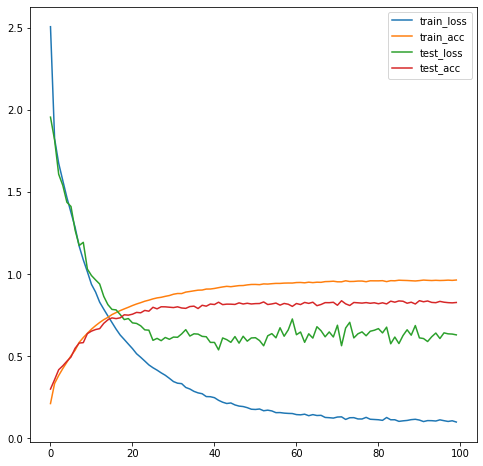

In [56]:
plt.figure(figsize=(8,8))

for i in history.keys():
    plt.plot(history[i])
    plt.legend(history.keys())